# Box Office Growth

<img src="images/airplane-header.jpg" alt="Business Opportunity" />

## Overview

Our client is a company that is interested in creating original video content through creation of a new movie studio, and wants to determine which types of films will be most successful in this new enterprise. This project analyses movie popularity data and box office revenues from multiple online databases to identify the most promising types of movies to be slated for initial rounds of production.

## Business Problem

The company wants to direct its resources towards creating new movie content that is popular and profitable. We will leverage these databases to identify the trends in recently popular movie genres through rating data, and pinpoint those genres that lead to large revenue streams and signficant return on investment for their production budgets.

## Data Understanding

For this analysis, we will make use of the Internet Movie DataBase ([IMDB](https://www.imdb.com/)), a SQLite database containing tables of movie data, including genre, rating, year, and individuals involved in production. We will preprocess the data to extract movie popularity metrics (number of reviews, average reviews) by genre to identify promising movie genres.

Additionally, we will analyze box office revenue databases from [The Numbers](https://www.the-numbers.com/) and [Box Office Mojo](https://www.boxofficemojo.com/), to identify which genres led to the greatest revenue and return on investment from the production budget.

<img src="images/plane-crash.jpg" width="300" alt="Accident data" />

#### Limitations of This Dataset

We are making a best-use analysis of the data we have at hand, which are movies that have been entered with reviews into these databases. This may not be reflective of all movies on the market, but we will draw relative conclusions by comparing among genres for those films who have ratings in these databases.

Additionally, while the rating data encompases many movies, only a subset of those films are included with box office revenue and production budgets, so our conclusions on profitability of films is drawn from this smaller data set.

In [2]:
#import necessary packages for analysis and visualization
import pandas as pd
import numpy as np
import sqlite3
import gzip

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### The Numbers database

In [3]:
#load The Numbers dataset (budgets and gross revenue)
df_TN = pd.read_csv('data/tn.movie_budgets.csv.gz', index_col=0)

#print the columns and the first 5 entries
df_TN.info()
df_TN.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


___

#### Box Office Mojo database

In [4]:
#load Box Office Mojo dataset (gross revenues)
df_BOM = pd.read_csv('data/bom.movie_gross.csv.gz')

#print the columns and the first 5 entries
df_BOM.info()
df_BOM.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


#### IMDB database (SQLite tables)

In [5]:
#load IMDB SQLite database and print out TABLE & COLUMN Names
conn = sqlite3.connect('data\im.db') 
curr = conn.cursor() 

#get table names from db
q = """SELECT name FROM sqlite_master WHERE type='table';""" 
curr.execute(q) 
table_list = curr.fetchall()
table_names = []
for item in table_list:
    table_names.append(item[0])

#print out column names from each table
for name in table_names: #loop over tables
    print('**Table:**  ' + name)
    q = """SELECT * FROM """ + name
    curr.execute(q)
    print('Columns:  ')
    for desc in curr.description: #loop over column names
        print(desc[0])
    print(' \n')

**Table:**  movie_basics
Columns:  
movie_id
primary_title
original_title
start_year
runtime_minutes
genres
 

**Table:**  directors
Columns:  
movie_id
person_id
 

**Table:**  known_for
Columns:  
person_id
movie_id
 

**Table:**  movie_akas
Columns:  
movie_id
ordering
title
region
language
types
attributes
is_original_title
 

**Table:**  movie_ratings
Columns:  
movie_id
averagerating
numvotes
 

**Table:**  persons
Columns:  
person_id
primary_name
birth_year
death_year
primary_profession
 

**Table:**  principals
Columns:  
movie_id
ordering
person_id
category
job
characters
 

**Table:**  writers
Columns:  
movie_id
person_id
 



# Data Preparation

### Data Cleaning

To standardize the dataset, I will convert all aircraft `Make` values to lowercase format (to avoid formatting differences).

Our primary measures of safety will be based on Injured/Uninjured counts, so we'll first convert any NaN values to be 0 (a reasonable interpretation given the entries of the dataset in these fields).

Further, we will restrict our focus to Non-Amateur-Built aircraft, as we're interested in running commercial flights.

In [4]:
#convert all the aircraft Makes to lowercase format (to standardize case)
aviation_df['Make'] = aviation_df['Make'].str.lower()

#clean injury count entries by setting NaN values to 0
aviation_df['Total.Fatal.Injuries'].replace(np.nan, 0, inplace=True)
aviation_df['Total.Serious.Injuries'].replace(np.nan, 0, inplace=True)
aviation_df['Total.Minor.Injuries'].replace(np.nan, 0, inplace=True)
aviation_df['Total.Uninjured'].replace(np.nan, 0, inplace=True)

#set Amateur.Built with NaN values to be assumed as a 'No'
aviation_df['Amateur.Built'].replace(np.nan, 'No', inplace=True)
#keep only non-Amateur.Built craft from the database (since we are focusing on commercial flights)
aviation_df = aviation_df[aviation_df['Amateur.Built']=='No']

#set phase of flight with NaN values to be 'Other'
aviation_df['Broad.phase.of.flight'].replace(np.nan, 'Other', inplace=True)

#convert Weather.Condition to standard formatting and store NaNs as unknown (UNK)
aviation_df['Weather.Condition'].replace(np.nan, 'UNK', inplace=True)
aviation_df['Weather.Condition'] = aviation_df['Weather.Condition'].str.upper()

#strip off the year from the date and store NaNs as 9999
aviation_df['Event.Date'] = pd.to_datetime(aviation_df['Event.Date'])
aviation_df['Year'] = [date.year for date in aviation_df['Event.Date']];
aviation_df['Year'].replace(np.nan,9999, inplace=True);
aviation_df['Year'] = aviation_df['Year'].astype(int)


### Feature Engineering

Since we only have access to flights with incidents, our main metric of **relative** risk will be the fraction of passengers that had either Fatal or Serious injuries. To this end, I create a column `Total.Passengers` that sums up all the *injured* and *uninjured* passengers, and another column `Total.FatalAndSerious` that sums up the most serious injuries and fatalities.

In [5]:
#add columns for Total.Passengers and Total.FatalAndSerious injuries
aviation_df['Total.Passengers'] = aviation_df['Total.Fatal.Injuries'] + aviation_df['Total.Serious.Injuries'] + aviation_df['Total.Minor.Injuries'] + aviation_df['Total.Uninjured']
aviation_df['Total.FatalAndSerious'] = aviation_df['Total.Fatal.Injuries'] + aviation_df['Total.Serious.Injuries']

#add column for flagging incidents that had at least 1 fatality
aviation_df['FatalIncident'] = aviation_df['Total.Fatal.Injuries'].map(lambda x: 1 if x>0 else 0)

#add column for simple incident count (for summary statistics by condition)
aviation_df['Incident'] = 1

In [6]:
#save cleaned dataset as CSV file (after restricting to columns we care about)
aviation_df.columns
aviation_df= aviation_df[['Latitude','Longitude','Aircraft.Category','Make','Model','Amateur.Built','Number.of.Engines','Engine.Type','Total.Fatal.Injuries','Total.FatalAndSerious','Total.Passengers','Weather.Condition','Broad.phase.of.flight','Year','FatalIncident','Incident']]
aviation_df.to_csv('./data/cleaned_aviation_df.csv')

## Analysis

### Trends in Incidents Over Time

First we will look at how the occurence of incidents and fatalities change over time, to see how safety in the airline business is trending.

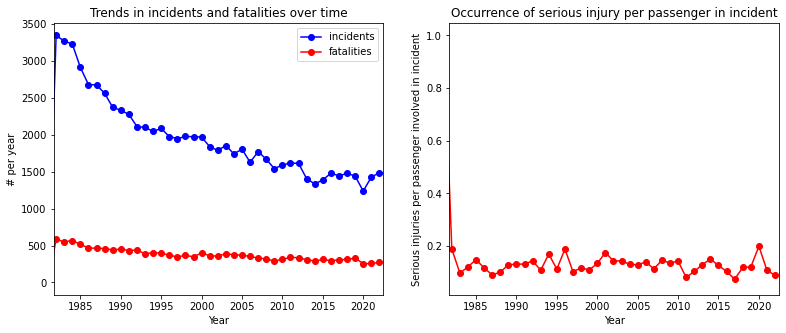

In [7]:
# group number of incidents and fatalities by year
incidents_by_year = aviation_df.groupby('Year')['Incident'].sum()
fatalities_by_year = aviation_df.groupby('Year')['FatalIncident'].sum()

# plot by year to show trends over time
fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(incidents_by_year.index, incidents_by_year,'bo-', label='incidents')
ax[0].plot(fatalities_by_year.index, fatalities_by_year,'ro-', label='fatalities')
ax[0].set_xlim(1981.7,2022.5)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('# per year')
ax[0].set_title('Trends in incidents and fatalities over time')
ax[0].legend()

# add up the number of total passengers and serious injuries (serious + fatal) by year
passengers_by_year = aviation_df.groupby('Year')['Total.Passengers'].sum()
seriousinjuries_by_year = aviation_df.groupby('Year')['Total.FatalAndSerious'].sum()

# plot the fraction of passengers in incidents that had serious injuries by year
ax[1].plot(passengers_by_year.index, seriousinjuries_by_year/passengers_by_year, 'ro-')
ax[1].set_xlim(1981.7, 2022.5)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Serious injuries per passenger involved in incident')
ax[1].set_title('Occurrence of serious injury per passenger in incident')

# save figure
fig.savefig('./images/incidents_over_time.png')

* From the above plots, we can see that the total number of incidents (and also fatalities) per year have been decreasing. If we make the assumption that the number of total flights (with and without incident) have been stable or increasing, then flights are becoming safer over time.

* The right plot shows that the fraction of passengers in each incident that sustain serious (or fatal) injuries, has also remained stable over time.

**Thus we can conclude that it a safe time to be getting into the airline business.**


Below, I will break down these incidents and severity by a number of distinct conditions.

### Accidents broken down by:

#### Category of Aircraft


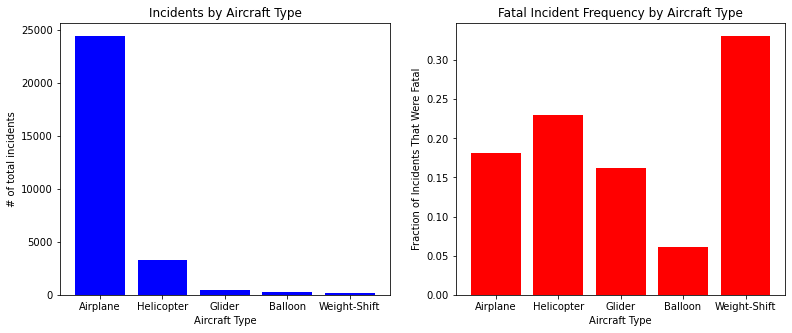

In [8]:
# group incidents by aircraft type
fatalincident_by_category=aviation_df.groupby('Aircraft.Category')['FatalIncident'].sum()
incident_by_category=aviation_df.groupby('Aircraft.Category')['Incident'].sum()

# sort by most common category of incidents and keep the top 5
incident_by_category.sort_values(ascending=False, inplace=True)
keep_categories = incident_by_category.index[:5]
fatalfreq_by_category = fatalincident_by_category.loc[keep_categories]/incident_by_category.loc[keep_categories] #calculate frequency of fatalities

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].bar(keep_categories, incident_by_category.loc[keep_categories], width=0.8, color='b')
ax[0].set_xlabel('Aircraft Type')
ax[0].set_ylabel('# of total incidents')
ax[0].set_title('Incidents by Aircraft Type')

ax[1].bar(keep_categories, fatalfreq_by_category, width=0.8, color='r')
ax[1].set_xlabel('Aircraft Type')
ax[1].set_ylabel('Fraction of Incidents That Were Fatal')
ax[1].set_title('Fatal Incident Frequency by Aircraft Type');

# save figure
fig.savefig('./images/incidents_by_category.png')

* From the above plot on the left we can see that airplanes had the most total incidents (probably because they were the dominant type of flight). 

* But the right plot shows that helicopters had a greater fraction of incidents that were fatal.

**From this we conclude that we should restrict ourselves to considering Airplanes as type of aircraft for the business.**

#### Make of Aircraft


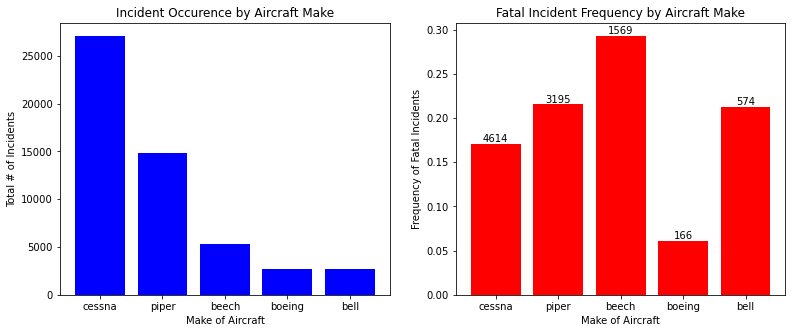

In [9]:
#get fatal incidents by Make of aircraft
fatalincident_by_make = aviation_df.groupby('Make')['FatalIncident'].sum()
incident_by_make = aviation_df.groupby('Make')['Incident'].sum()
incident_by_make.sort_values(ascending=False, inplace=True) #sort descending by number of incidents
keep_categories = incident_by_make.index[:5] # keep the 5 most common
fatalfreq_by_make = fatalincident_by_make/incident_by_make #calcuate frequency of fatal incidents

incident_by_make = incident_by_make.loc[keep_categories]
fatalincident_by_make = fatalincident_by_make.loc[keep_categories]
fatalfreq_by_make = fatalfreq_by_make.loc[keep_categories]

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].bar(keep_categories, incident_by_make, width=0.8, color='b')
ax[0].set_xlabel('Make of Aircraft')
ax[0].set_ylabel('Total # of Incidents')
ax[0].set_title('Incident Occurence by Aircraft Make')

#get odds of passengers having serious or fatal injuries in an incident
#totalpass_by_make = aviation_df.groupby('Make')['Total.Passengers'].sum()

# seriousinj_by_make = aviation_df.groupby('Make')['Total.FatalAndSerious'].sum()

# ax[1].bar(keep_categories, seriousinj_by_make.loc[keep_categories], width=0.8, color='r') #plot total number of serious injuries per make of aircraft
# ax[1].set_xlabel('Make of Aircraft')
# ax[1].set_ylabel('Total # of Passengers with Serious Injuries')
# ax[1].set_title('Serious Injury Occurence by Aircraft Make');

bar1 = ax[1].bar(keep_categories, fatalfreq_by_make, width=0.8, color='r')
ax[1].set_xlabel('Make of Aircraft')
ax[1].set_ylabel('Frequency of Fatal Incidents')
ax[1].set_title('Fatal Incident Frequency by Aircraft Make')
for i in range(5):
    rect = bar1[i]
    plt.text(rect.get_x() + rect.get_width()/2, rect.get_height(), f'{fatalincident_by_make.iloc[i]:.0f}', ha='center', va='bottom')

# save figure
fig.savefig('./images/incidentcount_by_make.png')

* The left plot above shows the count of incidents by Aircraft Make (for Makes with the top 5 # of incidents -- and presumably the most overall flights). From this we can see that Boeing and Bell aircraft have the lowest total incident counts.

* The right plot shows the odds of an incident being fatal by Aircraft Make. The number above each bar indicates the total number of fatal incidents by Make. Boeing has the lowest odds of an incident being fatal, and Bell's fatal incident freqency is on par with other airlines (but with a lower total fatal incident count).

**From this we can conclude that Boeing and Bell are the Make of Aircraft to be purchased that pose the lowest risk.**

#### Number of Engines

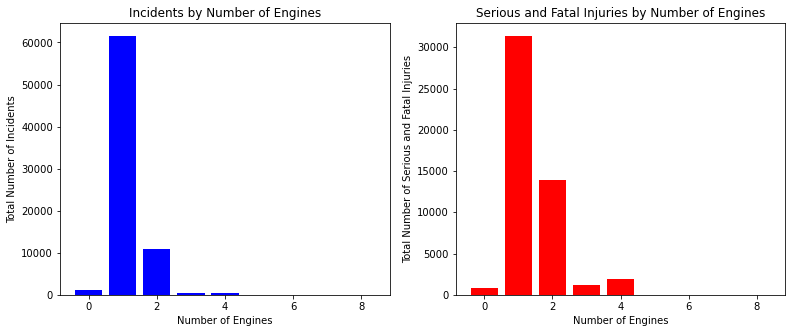

In [10]:
#tally up incidents by number of engines
fatalincident_by_engines = aviation_df.groupby('Number.of.Engines')['FatalIncident'].sum()
incidents_by_engines = aviation_df.groupby('Number.of.Engines')['Incident'].sum()
fatalfreq_by_engines = fatalincident_by_engines/incidents_by_engines

seriousinjuries_by_engines = aviation_df.groupby('Number.of.Engines')['Total.FatalAndSerious'].sum()

#plot total number of incidents by engine number (a proxy for number of flights)
fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].bar(incidents_by_engines.index, incidents_by_engines, width=0.8, color='b')
ax[0].set_xlabel('Number of Engines')
ax[0].set_ylabel('Total Number of Incidents')
ax[0].set_title('Incidents by Number of Engines')

#plot frequency of fatal incidents by engine number
# ax[1].bar(incidents_by_engines.index, fatalfreq_by_engines, width=0.8, color='r')
# ax[1].set_xlabel('Number of Engines')
# ax[1].set_ylabel('Frequency of Fatal Incidents')
# ax[1].set_title('Fatal Incident Frequency by Number of Engines');

ax[1].bar(seriousinjuries_by_engines.index, seriousinjuries_by_engines, width=0.8, color='r')
ax[1].set_xlabel('Number of Engines')
ax[1].set_ylabel('Total Number of Serious and Fatal Injuries')
ax[1].set_title('Serious and Fatal Injuries by Number of Engines')

# save figure
fig.savefig('./images/incidents_by_number_of_engines.png')

* The left plot shows that aircraft with 1 and 2 engines had the most incidents (and probably comprised the most total flights as well). Between these, however, 1 engine aircraft had by far the most incidents.

* The right plot shows that aircraft with 1 engine also had far more total serious and fatal injuries than 2 engine aircraft.

**We conclude that we should focus purchases on aircraft with 2 engines, as they are associated with fewer total incidents and serious and fatal injuries.**

#### Model of Aircraft (among Boeing and Bell)

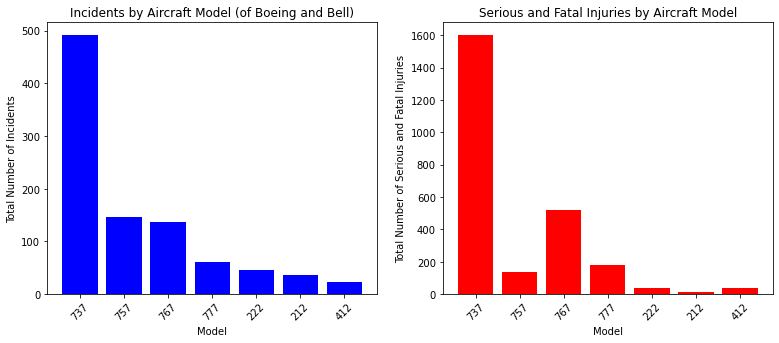

In [11]:
# restrict ourselves to 2 engine planes from Boeing and Bell
subset_df = aviation_df[aviation_df['Number.of.Engines']==2]
subset_df = subset_df[subset_df['Make'].isin(['boeing','bell'])]

#re-code all the 7*7 Model numbers to be simply 7*7 formatted (without trailing sub-codes)
subset_df['Model'] = subset_df['Model'].astype('string')

for i in subset_df.index:
    thismodel = subset_df.loc[i, 'Model']
    if type(thismodel) == str:
        if thismodel.find('737') != -1:
            subset_df.loc[i, 'Model'] = '737'
        elif thismodel.find('747') != -1:
            subset_df.loc[i, 'Model'] = '747'
        elif thismodel.find('757') != -1:
            subset_df.loc[i, 'Model'] = '757'
        elif thismodel.find('767') != -1:
            subset_df.loc[i, 'Model'] = '767'    
        elif thismodel.find('777') != -1:
            subset_df.loc[i, 'Model'] = '777'
        elif thismodel.find('787') != -1:
            subset_df.loc[i, 'Model'] = '787'
        elif thismodel.find('212') != -1:
            subset_df.loc[i, 'Model'] = '212'
        elif thismodel.find('222') != -1:
            subset_df.loc[i, 'Model'] = '222'
        elif thismodel.find('412') != -1:
            subset_df.loc[i, 'Model'] = '412'

#get incident counts by Model number (within these makes)
incident_by_model = subset_df.groupby('Model')['Incident'].sum()
incident_by_model.sort_values(ascending=False, inplace=True) #sort descending by number of incidents
keep_categories = incident_by_model.index[:7] #retain the models with the 7 largest # of incidents (we assume these are frequent flights as well)
incident_by_model = incident_by_model.loc[keep_categories]

#get serious and fatal injury counts by Model number
injuries_by_model = subset_df.groupby('Model')['Total.FatalAndSerious'].sum()
injuries_by_model = injuries_by_model.loc[keep_categories]

#plot incident counts by model number
fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].bar(incident_by_model.index, incident_by_model, width=0.8, color='b')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Total Number of Incidents')
ax[0].set_title('Incidents by Aircraft Model (of Boeing and Bell)')
ax[0].tick_params(axis='x', labelrotation = 45)

#plot injury totals by model number
ax[1].bar(injuries_by_model.index, injuries_by_model, width=0.8, color='r')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Total Number of Serious and Fatal Injuries')
ax[1].set_title('Serious and Fatal Injuries by Aircraft Model')
ax[1].tick_params(axis='x', labelrotation = 45)

# save figure
fig.savefig('./images/incidents_by_model.png')

We look at the aircraft models of 2-engine planes from Boeing and Bell to assess their safety record.

* The left plot shows that 737 model numbers had the most incidents, so we want to avoid those.

* The right plot shows 757 and 777 aircraft had much lower total numbers of injuries, while still having many fewer incidents than 737 (as shown on the left).

**We conclude that we should focus purchases of 757 and 777 aircraft, as they are associated with fewer total incidents and serious and fatal injuries.**

#### Phase of Flight

<ipython-input-12-524d8b8e5c28>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(keep_categories,Rotation=45);
<ipython-input-12-524d8b8e5c28>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].set_xticklabels(keep_categories,Rotation=45);
<ipython-input-12-524d8b8e5c28>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(keep_categories,Rotation=45);
<ipython-input-12-524d8b8e5c28>:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].set_xticklabels(keep_categories,Rotation=45);


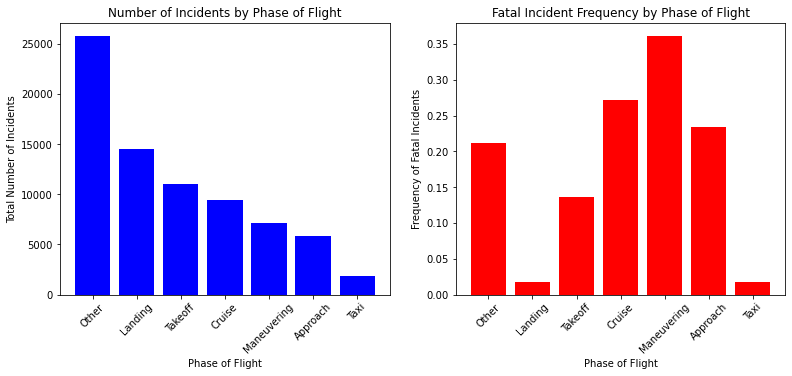

In [12]:
#group fatal incidents and incidents by Phase of Flight
fatalincident_by_phase = aviation_df.groupby('Broad.phase.of.flight')[['FatalIncident','Incident']].sum()

sorted_phase = fatalincident_by_phase['Incident'].sort_values(ascending=False) #sort descending by number of incidents
keep_categories = sorted_phase.index[:7] #keep the 7 most common phases with incidents

#plot incidents by phase of flight
fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].bar(keep_categories, fatalincident_by_phase.loc[keep_categories,'Incident'], color='b')
ax[0].set_xlabel('Phase of Flight')
ax[0].set_ylabel('Total Number of Incidents')
ax[0].set_title('Number of Incidents by Phase of Flight')
ax[0].set_xticklabels(keep_categories,Rotation=45);

#plot frequency of fatal incidents per phase of flight
ax[1].bar(keep_categories, fatalincident_by_phase.loc[keep_categories,'FatalIncident']/fatalincident_by_phase.loc[keep_categories,'Incident'], color='r')
ax[1].set_xlabel('Phase of Flight')
ax[1].set_ylabel('Frequency of Fatal Incidents')
ax[1].set_title('Fatal Incident Frequency by Phase of Flight')
ax[1].set_xticklabels(keep_categories,Rotation=45);

# save figure
fig.savefig('./images/incidents_by_phase_of_flight.png')

* The left plot shows that most incidents occurred during landing and takeoff (however there are many that are unclear and labelled 'Other').

* The right plot shows that maneuvering led to the greatest frequency of fatal incidents.

**We cannot avoid phases of flight, but it is good to be aware of when the most serious incidents occur in flight.**

#### Weather Conditions

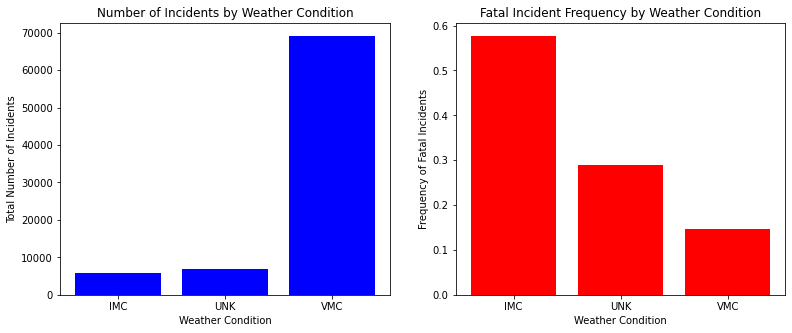

In [13]:
#group incidents and fatal incidents by weather condition
fatalincident_by_weather = aviation_df.groupby('Weather.Condition')[['FatalIncident','Incident']].sum()

#plot number of incidents by weather condition
fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].bar(fatalincident_by_weather.index, fatalincident_by_weather['Incident'], color='b')
ax[0].set_xlabel('Weather Condition')
ax[0].set_ylabel('Total Number of Incidents')
ax[0].set_title('Number of Incidents by Weather Condition')

#plot frequency of incidents that are fatal by weather condition
ax[1].bar(fatalincident_by_weather.index, fatalincident_by_weather['FatalIncident']/fatalincident_by_weather['Incident'], color='r')
ax[1].set_xlabel('Weather Condition')
ax[1].set_ylabel('Frequency of Fatal Incidents')
ax[1].set_title('Fatal Incident Frequency by Weather Condition');

# save figure
fig.savefig('./images/incidents_by_weather_conditions.png')

* The left plot shows that most incidents occurred during visible flying conditions (VMC).

* However, the right plot shows that the risk of fatal incidents is much higher during instrument control only weather conditions (IMC).

**Weather is an unavoidable factor, however it is good to be aware that most incidents occurred during visible flying conditions, though the odds of an incident leading to a fatality is higher during instrument control conditions.**

## Conclusions

These analyses suggest three main recommendations for the company as it enters the commercial and private airline market.

* They should focus purchases on Aircraft Makes from Boeing and Bell, as they have fewer incidents.

* They should focus on aircraft with 2 engines, as they are have far fewer incidents than 1 engine planes.

* They should focus first purchases on 757 and 777 models of aircraft as these have relatively few incidents and serious injuries (especially compared to 737 models).


## Future Steps

Going forward, additional analyses and databases can help identify promising ways to grow the business with minimal risk beyond these first preliminary steps.

* What are the flight routes the company should prioritize as they grow the business?

* Are there times of day that are safer overall for operating these kinds of flights?

* Identify flight databases that also list the total number of flights (with and without incidents) in order to better understand the context for these accident database analyses.